In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from common_pyfuncs import *


sol_filename = "./bin/sundials2_sol.csv"
SDsol_filename = "./bin/sundials2_SDsol.csv"
setup_filename = "./bin/sundials2_setup.txt"
#SDsol_filename = "./collsonly32768_SDsol.csv"
#SDsol_filename = "./collsonly8192_SDsol.csv"


In [2]:
### read in constants and intial setup from .hpp or .txt files
#CONSTS, notfloats = read_cpp_into_floats("./constants.hpp")
#INIT, notfloats2 = read_cpp_into_floats("./init.hpp") 
CONSTS, notfloats = read_cpp_into_floats(setup_filename)
INITS = {
  "iW"      : CONSTS["iW"],
  "iVOL"    : CONSTS["iVOL"],
  "nsupers" : int(CONSTS["nsupers"]),
}
MCONSTS = {
  "RGAS_DRY"   : CONSTS["RGAS_UNIV"]/CONSTS["MR_DRY"],
  "RGAS_V"     : CONSTS["RGAS_UNIV"]/CONSTS["MR_WATER"],
  "CP0"        : CONSTS["CP_DRY"],
  "MR0"        : CONSTS["MR_DRY"],
  "Mr_ratio"   : CONSTS["MR_WATER"]/CONSTS["MR_DRY"],
}
MCONSTS["RHO0"]       = CONSTS["P0"]/(MCONSTS["RGAS_DRY"]*CONSTS["TEMP0"])

print("---- Additional Constants Derived -----")
for c in MCONSTS:
  print(c, "=", MCONSTS[c])
nsupers    = int(INITS["nsupers"])                  
VOL = INITS["iVOL"]                                # parcel volume [m]                    
print("---------------------------------------------")


---- Constants read from  ./bin/sundials2_setup.txt -----
iVOL = 1000000.0
iW = 0.5
temp_init = 273.15
p_init = 100000.0
relh_init = 60.0
qc_init = 0.0
nout = 1000.0
rtol = 1e-06
supers = 32768.0
nsupers = 8192.0
coll_tstep = 1.0
G = 9.80665
RGAS_UNIV = 8.314462618
MR_WATER = 0.01801528
MR_DRY = 0.0289647
LATENT_V = 2437300.0
CP_DRY = 1004.9
CP_V = 1864.0
C_L = 4180.0
RHO_DRY = 1.177
RHO_L = 1000.0
e = 1000000.0
RHO_SOL = 2200.0
MR_SOL = 0.058443
IONIC = 2.0
W0 = 0.5
TIME0 = 4000.0
P0 = 100000.0
TEMP0 = 273.15
R0 = 1e-06
---------------------------------------------
---- Not floats read from  ./bin/sundials2_setup.txt -----
tspan[2] = {0, 4000}
atols[2] = {1e-6, 1e-6}
iRho_l = dlc::Rho_l
iRho_sol = dlc::Rho_sol
iMr_sol = dlc::Mr_sol
iIONIC = dlc::IONIC
RGAS_DRY = RGAS_UNIV/MR_DRY
RGAS_V = RGAS_UNIV/MR_WATER
DYNVISC = 18.45*1e-6
LATENT_RGAS_V = LATENT_V/RGAS_V
RHO0 = P0/(DC::RGAS_DRY*TEMP0)
CP0 = DC::CP_DRY
MR0 = DC::MR_DRY
F0 = TIME0/(RHO0*R0*R0)
Mr_ratio = DC::MR_WATER/DC::MR_DRY
Cp_d

In [3]:
### Helper Functions 
def saturation_pressure(T):
  ''' Calculate the equilibrium vapor pressure 
  of water over liquid water ie. the
  saturation pressure (psat [Pa]). Equation taken from
  typhon.physics.thermodynamics.e_eq_water_mk.'''
  
  if np.any(T <= 0):
      err = 'T must be larger than 0K.'
      raise ValueError(err)

  lnpsat = (54.842763                    # ln(psat) [Pa]
        - 6763.22 / T
        - 4.21 * np.log(T)
        + 0.000367 * T
        + np.tanh(0.0415 * (T - 218.8))
        * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T))

  return np.exp(lnpsat)               # psat [Pa]



def dry_pot_temp(Temp, P, qv):
    ''' calculate potential Temperature [K]
    assuming moist (unsaturated) air with
    vapour content qv '''
   
    Cpdry = CONSTS["CP_DRY"]
    Cpv = CONSTS["CP_V"]
    Rgasdry = MCONSTS["RGAS_DRY"]
    Rgasv = MCONSTS["RGAS_V"]

    Cp =  Cpdry * (1+qv*Cpv/Cpdry)/(1+qv)
    Rgas = Rgasdry *(1+qv*Rgasv/Rgasdry)/(1+qv)
    
    Theta = Temp*(P[0]/P)**(Rgas/Cp)
    
    return Theta


### Plotting functions
def axplt(ax, x, y, xlab=None, ylab=None, lab=None, c=0, l='-'):
    if type(c)==type(0):
        c= 'C'+str(c)
    ax.plot(x,y, label=lab, color=c, linestyle=l)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)



In [4]:
#### Get data and Re-Dimensionalise Solution ###
t, p, temp, qv, qc = get_soldata(sol_filename, CONSTS["TIME0"], CONSTS["P0"], CONSTS["TEMP0"]) 
eps, r, m_sol = get_SDdata(SDsol_filename, nsupers, CONSTS["R0"], MCONSTS["RHO0"]) 
w = INITS["iW"]
z = t*w
SDprops = CommonSuperdropProperties(nsupers, VOL, CONSTS["RHO_L"], CONSTS["RHO_SOL"], 
                CONSTS["MR_SOL"], CONSTS["IONIC"])


### Some derived quantities
# theta = dry_pot_temp(temp, p, qv)                      # parcel potential temp
# gamma = (MCONSTS["RGAS_DRY"]/CONSTS["CP_DRY"]) 
# dry_adia = temp[0]*(p/p[0])**gamma            # dry adiabatic temp
# dry_adia_theta = dry_adia*(p[0]/p)**gamma    # dry adiabatic theta (=const)

# pv = qv*p/(MCONSTS["Mr_ratio"] + qv) 
# psat = saturation_pressure(temp)
# relh = pv/psat
# qsat = MCONSTS["Mr_ratio"] * psat/(p-pv) 
# s = qv/qsat - 1   


--- Raw Data Shapes ---
variables: t, p, temp, qv, qc
(1001,) (1001,) (1001,) (1001,) (1001,)
--- Non Dimensional Max/Mins of Data ---
time: 0.0 0.999999999999918
p: 1.0 1.0
temp: 1.0 1.0
(qv, qc) (0.00228934479239319, 0.0) (0.00228934479239319, 0.0)
--- Raw SD Data Shapes ---
variables: eps, r, m_sol
(1001, 8192) (1001, 8192) (1001, 8192)
--- Non Dimensional Max/Mins of Data ---
droplet eps: 15625.0 1024000000.0
droplet r: 1.24241997564001 4423.67476104008
droplet m_sol: 13857.4372748303 625499854071688.0
---- Superdrop Properties -----
nsupers = 8192
parcel volume = 1000000.0 m^3
RHO_L = 1000.0 Kg/m^3
RHO_SOL = 2200.0 Kg/m^3
MR_SOL = 0.058443 Kg/mol
IONIC = 2.0
-------------------------------


individual superdroplet evolutions:


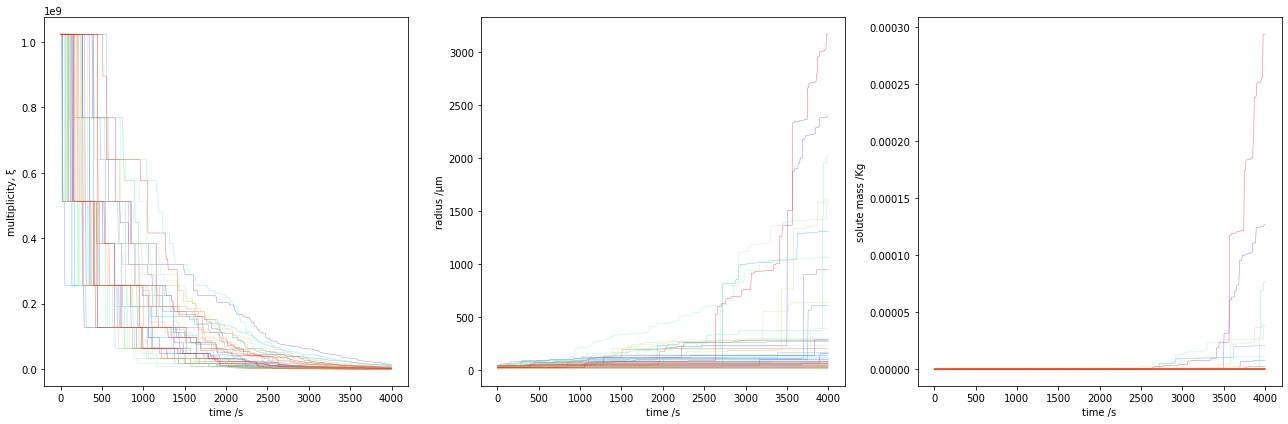

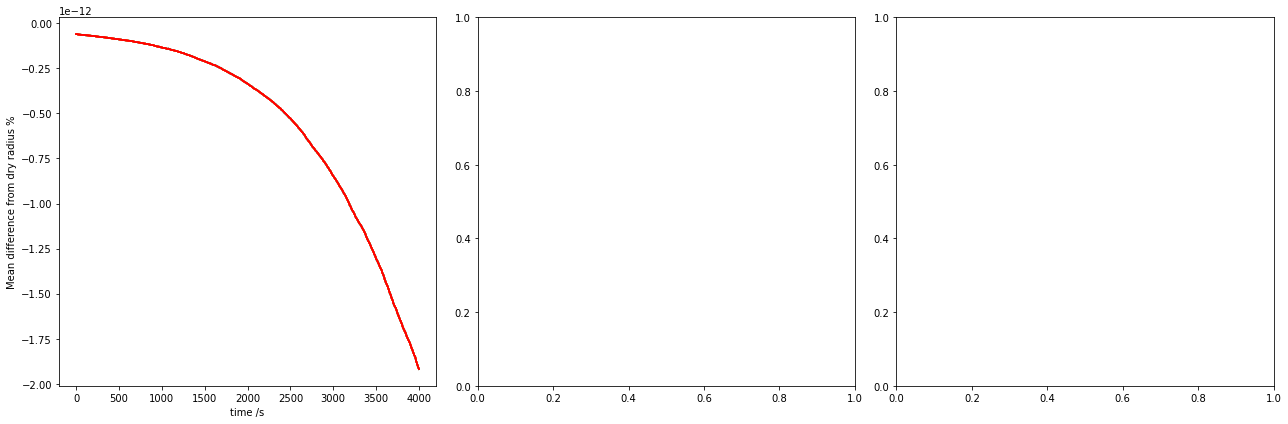

In [5]:
print("individual superdroplet evolutions:")
n = 50
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18,6))
colors=plt.cm.rainbow(np.linspace(0,1,n))
for i,c in zip(range(n), colors):
  axplt(axs[0], t, eps[:,i], xlab="time /s", ylab="multiplicity, \u03BE", c=c)
  axplt(axs[1], t, r[:,i]*1e6, xlab="time /s", ylab="radius /\u03BCm", c=c)
  axplt(axs[2], t, m_sol[:,i], xlab="time /s", ylab="solute mass /Kg",c=c)

for ax in axs:
  for line in ax.get_lines():
      line.set_linewidth(0.3)
plt.tight_layout()


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18,6))
dry_r = (3*m_sol/(4*np.pi*SDprops.RHO_SOL))**(1/3)
fracdiff = np.mean((r-dry_r)/dry_r, axis=1)
for i,c in zip(range(n), colors):
  axplt(axs[0], t, fracdiff*100, xlab="time /s", ylab="Mean difference from dry radius %", c=c)
plt.tight_layout()


total mass density as if water at t[0] =  1.0078415872998892 g m$^{-3}$
total mass density as if water at t[-1] =  1.0078415872993973 g m$^{-3}$
total solute mass density at t[0] =  2.217251492059756 g m$^{-3}$
total solute mass density at t[-1] =  2.2172514920597566 g m$^{-3}$


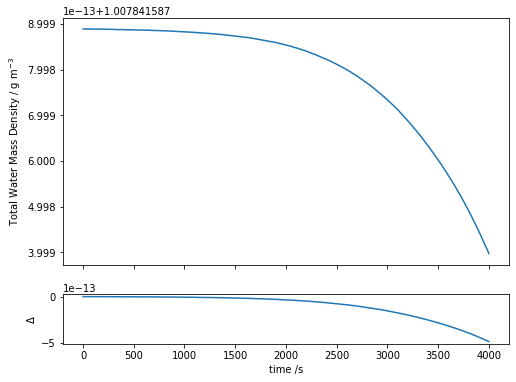

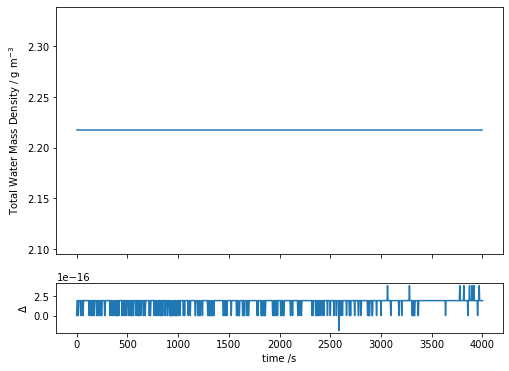

In [6]:
totmassdens = np.sum(eps*SDprops.m(r, 0)/VOL, axis=1)
print("total mass density as if water at t[0] = ", totmassdens[0]*1000, "g m$^{-3}$")
print("total mass density as if water at t[-1] = ", totmassdens[-1]*1000, "g m$^{-3}$")
gd = dict(height_ratios=[5,1])
fig, axs = plt.subplots(ncols=1, nrows=2, 
            figsize=(8,6), gridspec_kw=gd, sharex=True)
axplt(axs[0], t, totmassdens*1000, ylab="Total Water Mass Density / g m$^{-3}$")
axplt(axs[1], t, (totmassdens-totmassdens[0])/totmassdens[0], xlab="time /s", ylab="\u0394")


totmsoldens = np.sum(eps*m_sol/VOL, axis=1)
print("total solute mass density at t[0] = ", totmsoldens[0]*1000, "g m$^{-3}$")
print("total solute mass density at t[-1] = ", totmsoldens[-1]*1000, "g m$^{-3}$")
gd = dict(height_ratios=[5,1])
fig, axs = plt.subplots(ncols=1, nrows=2, 
            figsize=(8,6), gridspec_kw=gd, sharex=True)
axplt(axs[0], t, totmsoldens*1000, ylab="Total Water Mass Density / g m$^{-3}$")
axplt(axs[1], t, (totmsoldens-totmsoldens[0])/totmsoldens[0], xlab="time /s", ylab="\u0394")

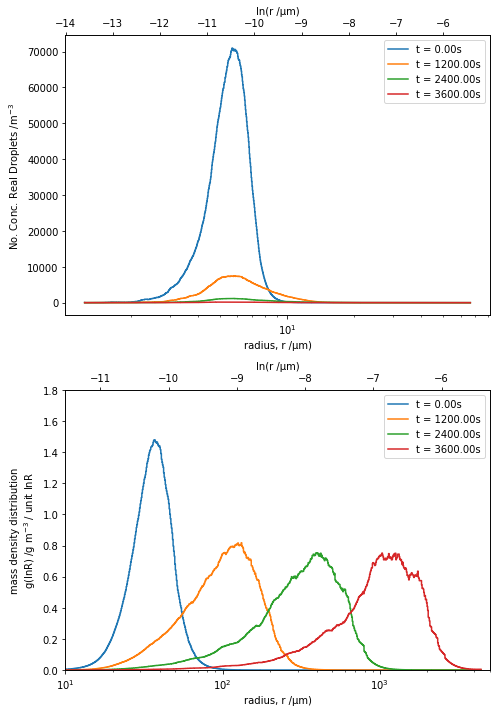

In [7]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
nbins = 1000
rspan = [np.amin(r), np.amax(r)]
#rspan = [0.62e-6, 6.34e-2]
nplts = 4
#tplt = np.linspace(t[0], t[-1], nplts)
tplt = [0, 1200, 2400, 3600]
smoothsig = 0.62*nsupers**(-1/5)
#smoothsig = False


linear_twinax(ax1, np.log(r[0,:]), eps[0,:]/VOL)
wghts0 = eps[0,:]*SDprops.m(r[0,:], 0)/VOL*1000
#wghts0 = eps[0,:]/VOL*SDprops.m_w(r[0,:], m_sol[0,:])*1000
ax2b = linear_twinax(ax2, np.log(r[0,:]), wghts0)
for i in range(nplts):
        ind = np.argmin(abs(t-tplt[i]))
        tlab = 't = {:.2f}s'.format(t[ind])
        c = 'C'+str(i)
        logr_distribution(rspan, nbins, r[ind,:], eps[ind,:]/VOL, ax=ax1, 
                step=True, lab=tlab, c=c, ylab="No. Conc. Real Droplets /m$^{-3}$",
                perlnR=False, smooth=smoothsig)

        wghts = eps[ind,:]*SDprops.m(r[ind,:], 0)/VOL*1000
        #wghts = eps[ind,:]/VOL*SDprops.m_w(r[ind,:], m_sol[ind,:])*1000
        logr_distribution(rspan, nbins, r[ind,:], wghts, ax=ax2, 
                step=True, lab=tlab, c=c, 
                ylab="mass density distribution\n"+\
                        "g(lnR) /g m$^{-3}$ / unit lnR",
                perlnR=True, smooth=smoothsig)
#ax1.set_yscale('log')
#ax2.set_yscale('log')
ax2.set_ylim([0,1.8])
xlims = [10, 5000]
ax2.set_xlim([np.log(xlims[0]*1e-6),np.log(xlims[1]*1e-6)])
ax2b.set_xlim(xlims)

plt.tight_layout()



0.0 2.2172514920597566 1.0078415872998894
1199.99999999998 2.217251492059756 1.0078415872998892
2399.999999999848 2.2172514920597566 1.0078415872998892
3599.999999999716 2.2172514920597566 1.0078415872998894


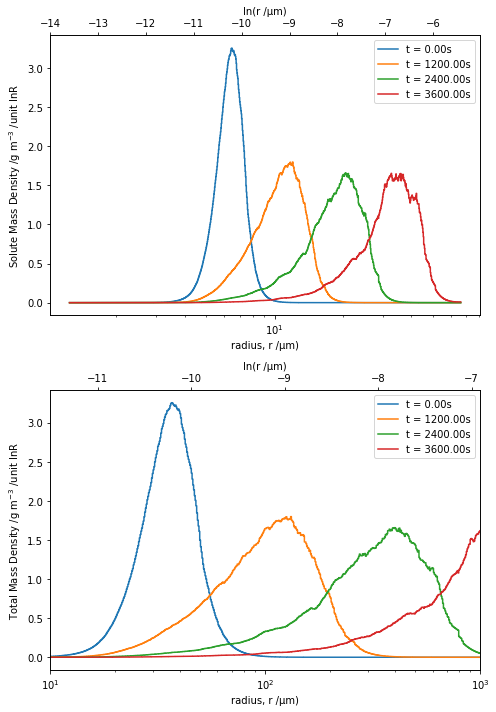

In [8]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
nbins = 1000
rspan = [np.amin(r), np.amax(r)]
nplts = 4
tplt = [0, 1200, 2400, 3600]
smoothsig = 0.62*nsupers**(-1/5)
#smoothsig = False


linear_twinax(ax1, np.log(r[0,:]), eps[0,:]*m_sol[0,:]/VOL*1000)
wghts = eps[0,:]*SDprops.m(r[0,:], m_sol[0,:])/VOL*1000
ax2b = linear_twinax(ax2, np.log(r[0,:]), wghts0)
for i in range(nplts):
        ind = np.argmin(abs(t-tplt[i]))
        tlab = 't = {:.2f}s'.format(t[ind])
        c = 'C'+str(i)
        logr_distribution(rspan, nbins, r[ind,:], eps[ind,:]*m_sol[ind,:]/VOL*1000, ax=ax1, 
                step=True, lab=tlab, c=c, ylab="Solute Mass Density /g m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)

        wghts = eps[ind,:]*SDprops.m(r[ind,:], m_sol[ind,:])/VOL*1000
        logr_distribution(rspan, nbins, r[ind,:], wghts, ax=ax2, 
                step=True, lab=tlab, c=c, 
                ylab="Total Mass Density /g m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)
        
        sum1 = np.sum(eps[ind,:]*m_sol[ind,:]/VOL*1000)
        sum2 = np.sum(eps[ind,:]*m_sol[ind,:]/VOL*1000*SDprops.RHO_L/SDprops.RHO_SOL)
        print(t[ind], sum1, sum2)

ax2.set_xlim([np.log(10e-6),np.log(1000e-6)])
ax2b.set_xlim([10,1000])
plt.tight_layout()




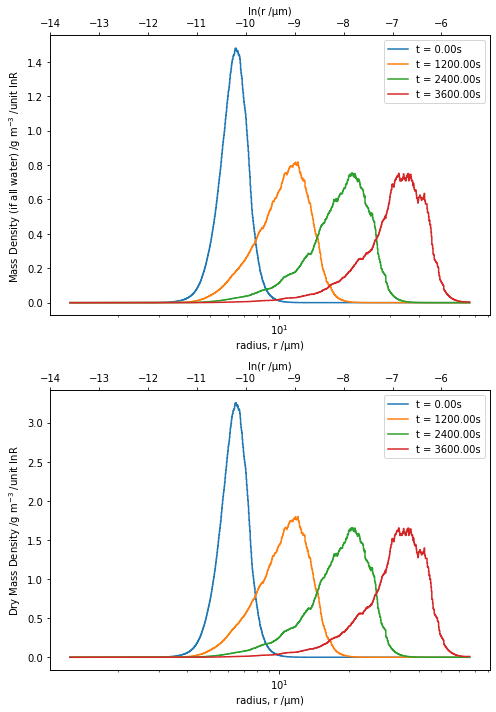

In [10]:


fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(7,10))

wghts0 = eps[0,:]*SDprops.m(r[0,:], 0)/VOL*1000
linear_twinax(ax1, np.log(r[0,:]), wghts0)
dry_r0 = (3*m_sol[0,:]/(4*np.pi*SDprops.RHO_SOL))**(1/3)
dry_wghts0 = eps[0,:]*SDprops.m(dry_r0, m_sol[0,:])/VOL*1000
ax2b = linear_twinax(ax2, np.log(r[0,:]), wghts0)
for i in range(nplts):
        ind = np.argmin(abs(t-tplt[i]))
        tlab = 't = {:.2f}s'.format(t[ind])
        c = 'C'+str(i)
        wghts = eps[ind,:]*SDprops.m(r[ind,:], 0)/VOL*1000
        logr_distribution(rspan, nbins, r[ind,:], wghts, ax=ax1, 
                step=True, lab=tlab, c=c, ylab="Mass Density (if all water) /g m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)


        dry_r = (3*m_sol[ind,:]/(4*np.pi*SDprops.RHO_SOL))**(1/3)
        dry_wghts = eps[ind,:]*SDprops.m(dry_r, m_sol[ind,:])/VOL*1000
        logr_distribution(rspan, nbins, r[ind,:], dry_wghts, ax=ax2, 
                step=True, lab=tlab, c=c, 
                ylab="Dry Mass Density /g m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)
        
# ax2.set_xlim([np.log(10e-6),np.log(1000e-6)])
# ax2b.set_xlim([10,1000])
plt.tight_layout()



